# Notebook 01: Exploratory Data Analysis & Business Storytelling

## Dynamic Pricing in Ride-Sharing: Understanding Surge Pricing

**Objective**: Explore the Uber/Lyft dataset to understand when, where, and why surge pricing occurs, building a narrative for stakeholders.

### Key Questions
1. When does surge pricing activate? (time patterns)
2. Where is surge most common? (geographic patterns)
3. How does weather influence pricing?
4. Do Uber and Lyft use different surge strategies?
5. What drives price variation beyond surge?

---

## Setup

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Project imports
import sys
sys.path.insert(0, str(Path.cwd().parent / 'src'))

from data.loader import load_cab_rides, load_weather
from data.preprocessing import preprocess_rides, engineer_features, merge_with_weather
from visualization.plots import (
    set_publication_style, 
    save_figure,
    plot_surge_distribution,
    plot_hourly_pattern,
    plot_price_vs_surge,
    PALETTE
)

# Set publication style
set_publication_style()

# Paths
DATA_DIR = Path.cwd().parent / 'data'
OUTPUT_DIR = Path.cwd().parent / 'outputs' / 'figures'

print("Setup complete!")

Setup complete!


## 1. Load and Explore Raw Data

In [2]:
# Load raw data
rides_raw = load_cab_rides()
weather_raw = load_weather()

print(f"Rides dataset: {len(rides_raw):,} rows")
print(f"Weather dataset: {len(weather_raw):,} rows")
print(f"\nDate range: {rides_raw['time_stamp'].min()} to {rides_raw['time_stamp'].max()}")

Rides dataset: 693,071 rows
Weather dataset: 6,276 rows

Date range: 2018-11-26 03:40:46.318000 to 2018-12-18 19:15:10.943000


In [3]:
# Examine rides data
rides_raw.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,2018-12-16 09:30:07.890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,2018-11-27 02:00:23.677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,2018-11-28 01:00:22.198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,2018-11-30 04:53:02.749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,2018-11-29 03:49:20.223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


In [4]:
# Data types and missing values
print("Data Types:")
print(rides_raw.dtypes)
print("\nMissing Values:")
print(rides_raw.isnull().sum())

Data Types:
distance                   float64
cab_type                    object
time_stamp          datetime64[ns]
destination                 object
source                      object
price                      float64
surge_multiplier           float64
id                          object
product_id                  object
name                        object
dtype: object

Missing Values:
distance                0
cab_type                0
time_stamp              0
destination             0
source                  0
price               55095
surge_multiplier        0
id                      0
product_id              0
name                    0
dtype: int64


### Key Observation: Missing Prices

Notice that we have **~55,000 missing prices**. These likely represent failed ride requests (no driver available, user cancelled, etc.). This is important business context - surge pricing affects availability!

In [5]:
# Analyze missing prices
missing_by_type = rides_raw.groupby('cab_type')['price'].apply(lambda x: x.isnull().mean() * 100)
print("Missing price rate by cab type:")
print(missing_by_type)

Missing price rate by cab type:
cab_type
Lyft     0.000000
Uber    14.285788
Name: price, dtype: float64


## 2. Data Preprocessing

Let's clean the data and engineer features for analysis.

In [6]:
# Preprocess rides
rides = preprocess_rides(rides_raw)
rides = engineer_features(rides)

print(f"Cleaned dataset: {len(rides):,} rows")
print(f"\nNew features created: {set(rides.columns) - set(rides_raw.columns)}")

Cleaned dataset: 637,976 rows

New features created: {'is_weekend', 'price_per_mile', 'is_rush_hour', 'day_of_week', 'hour', 'time_of_day'}


In [7]:
# Merge with weather
df = merge_with_weather(rides, weather_raw)
print(f"Merged dataset: {len(df):,} rows")
print(f"Weather columns added: {['temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind']}")

Merged dataset: 637,976 rows
Weather columns added: ['temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind']


In [8]:
# Quick summary
df.describe()

,distance,time_stamp,price,surge_multiplier,hour,day_of_week,price_per_mile,temp,clouds,pressure,rain,humidity,wind
count,637976.000000,637976,637976.000000,637976.000000,637976.000000,637976.000000,637976.000000,637976.000000,637976.000000,637976.000000,93547.000000,637976.000000,637976.000000
mean,2.189261,2018-12-05 21:34:05.413374464,16.545125,1.015068,11.618528,2.781699,9.687674,39.205433,0.669611,1010.211294,0.046078,0.747566,6.954336
min,0.020000,2018-11-26 03:40:46.318000,2.500000,1.000000,0.000000,0.000000,0.556586,19.620000,0.000000,988.250000,0.000200,0.450000,0.290000
25%,1.270000,2018-11-28 22:26:08.211000064,9.000000,1.000000,6.000000,1.000000,4.661017,36.160000,0.430000,999.950000,0.004000,0.650000,3.650000
50%,2.160000,2018-12-02 07:52:59.568000,13.500000,1.000000,12.000000,3.000000,7.492326,40.090000,0.760000,1009.350000,0.012900,0.730000,6.770000
75%,2.930000,2018-12-14 22:45:04.678000128,22.500000,1.000000,18.000000,5.000000,11.538462,43.700000,0.970000,1021.870000,0.035400,0.870000,9.920000
max,7.860000,2018-12-18 19:15:10.943000,97.500000,3.000000,23.000000,6.000000,1375.000000,55.410000,1.000000,1035.120000,0.780700,0.990000,18.180000
std,1.135413,NaN,9.324359,0.095422,6.948776,2.056670,13.705589,6.605349,0.314107,13.367658,0.093931,0.128998,3.658039


## 3. Understanding Surge Pricing

### 3.1 What is Surge Pricing?

Surge pricing (dynamic pricing) adjusts prices based on real-time demand and supply. When demand exceeds supply:
- Prices increase (surge multiplier > 1.0)
- This incentivizes more drivers to work
- And balances demand by discouraging price-sensitive riders

Let's explore how surge manifests in our data.

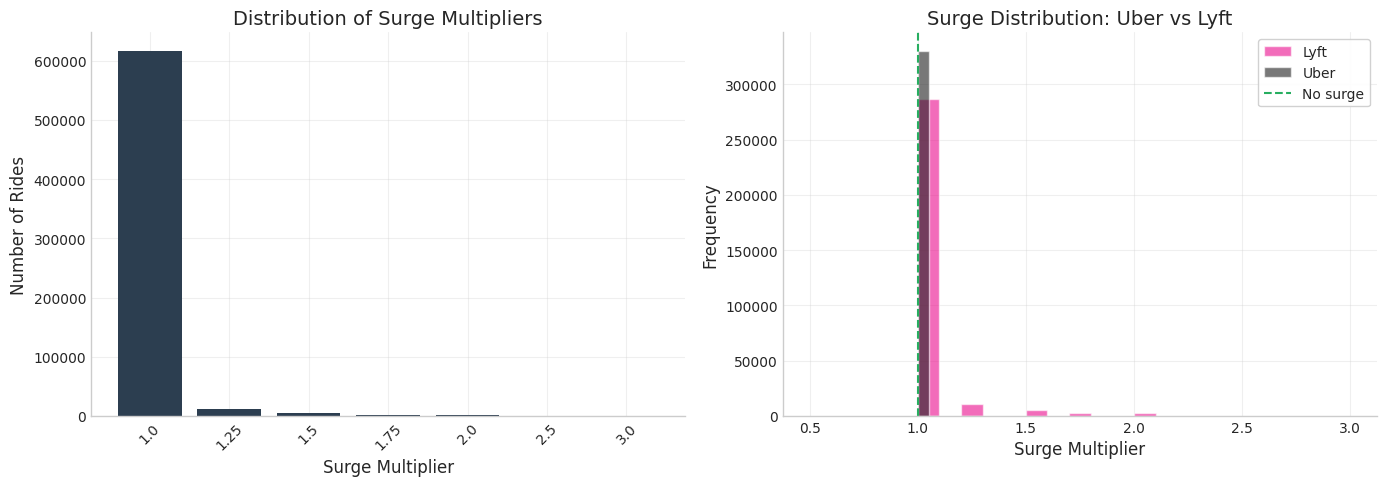

In [9]:
# Surge multiplier distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Overall distribution
ax1 = axes[0]
surge_counts = df['surge_multiplier'].value_counts().sort_index()
ax1.bar(surge_counts.index.astype(str), surge_counts.values, color=PALETTE['primary'])
ax1.set_xlabel('Surge Multiplier')
ax1.set_ylabel('Number of Rides')
ax1.set_title('Distribution of Surge Multipliers')
ax1.tick_params(axis='x', rotation=45)

# Right: By cab type
ax2 = axes[1]
plot_surge_distribution(df, hue_col='cab_type', ax=ax2)
ax2.set_title('Surge Distribution: Uber vs Lyft')

plt.tight_layout()
plt.show()

In [10]:
# Percentage of rides with surge
surge_rates = df.groupby('cab_type')['surge_multiplier'].apply(
    lambda x: (x > 1.0).mean() * 100
).round(1)

print("Percentage of rides with surge pricing:")
for cab, rate in surge_rates.items():
    print(f"  {cab}: {rate}%")
print(f"\nOverall: {(df['surge_multiplier'] > 1.0).mean() * 100:.1f}%")

Percentage of rides with surge pricing:
  Lyft: 6.8%
  Uber: 0.0%

Overall: 3.3%


### Key Finding: Dataset Limitation — Uber Surge Not Captured

**Important observation**: In this dataset, only Lyft shows surge pricing (multipliers from 1.25x to 3.0x). Uber rides always have a surge multiplier of 1.0.

**Why is this?** This is a **dataset limitation**, not a reflection of Uber's actual pricing strategy:

1. **Upfront Pricing**: In 2016-2017, Uber transitioned to "Upfront Pricing" where the surge is baked into the final price shown to users, rather than displayed as a separate multiplier. The API likely doesn't expose this multiplier.

2. **Data Collection Method**: This dataset was likely collected via API scraping, capturing only what the APIs exposed. Lyft's explicit surge multiplier was visible; Uber's dynamic pricing was not.

3. **Uber Does Use Dynamic Pricing**: In reality, Uber uses sophisticated demand-based pricing. The minimal price/mile variation (1.12x across hours for UberX) suggests the data simply doesn't capture this signal.

**Implication for Analysis**: Our surge analysis will focus on Lyft's explicit surge multipliers. For Uber, we'll analyze base price variation instead.

### 3.2 When Does Surge Occur? (Temporal Patterns)

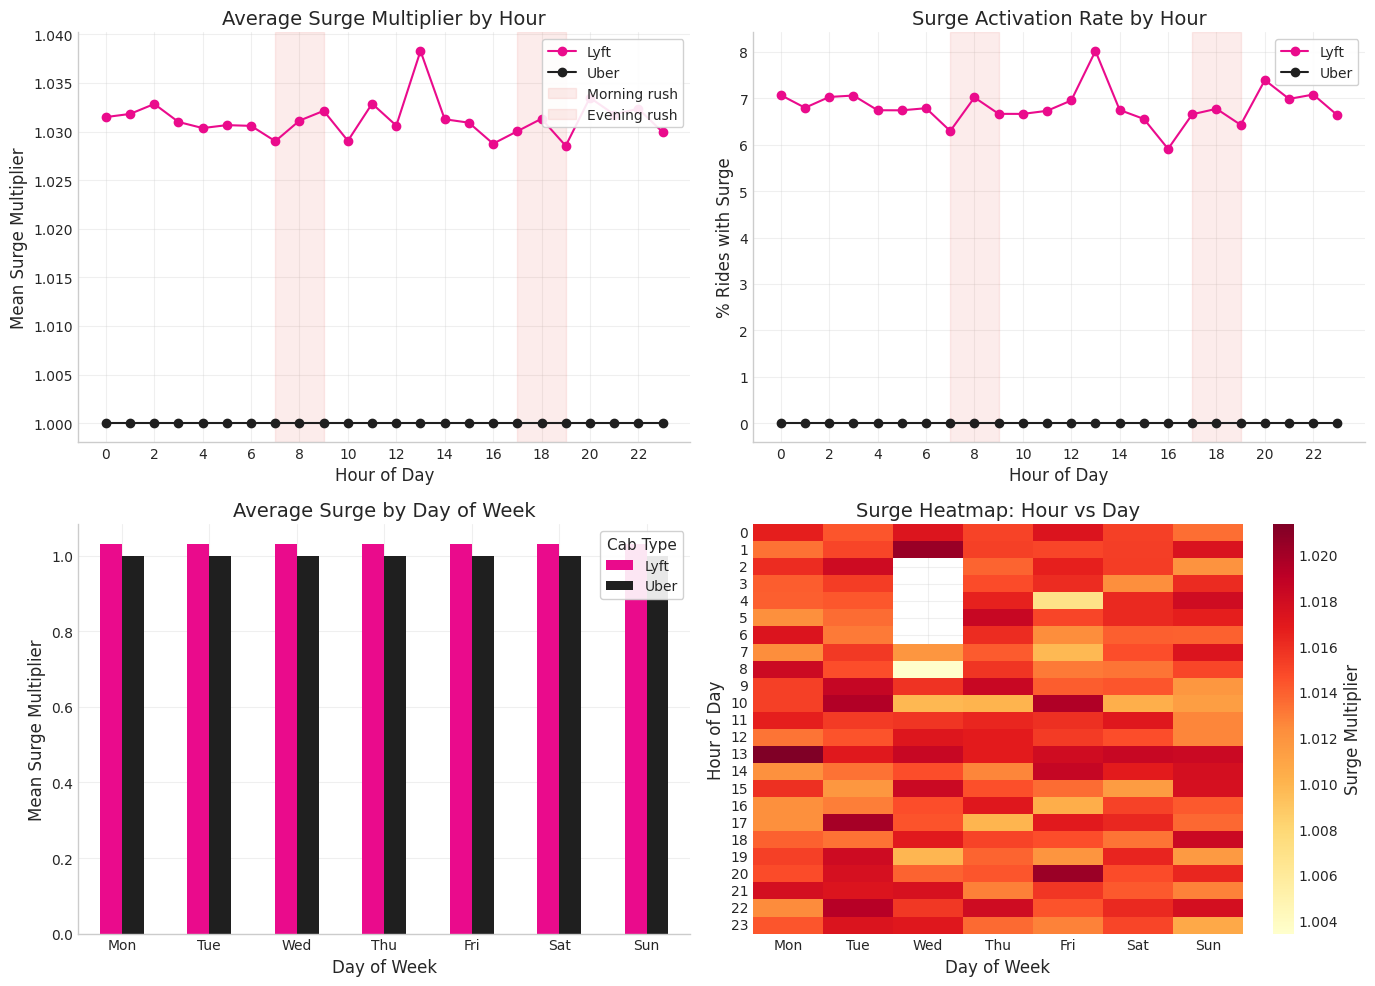

In [11]:
# Hourly surge patterns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top left: Average surge by hour
plot_hourly_pattern(
    df, 'surge_multiplier', hue_col='cab_type',
    title='Average Surge Multiplier by Hour',
    ylabel='Mean Surge Multiplier',
    ax=axes[0, 0]
)

# Top right: Surge rate (% of rides with surge) by hour
hourly_surge_rate = df.groupby(['hour', 'cab_type'])['surge_multiplier'].apply(
    lambda x: (x > 1.0).mean() * 100
).unstack()

ax = axes[0, 1]
for col in hourly_surge_rate.columns:
    color = PALETTE['uber'] if 'uber' in col.lower() else PALETTE['lyft']
    ax.plot(hourly_surge_rate.index, hourly_surge_rate[col], marker='o', label=col, color=color)
ax.axvspan(7, 9, alpha=0.1, color=PALETTE['warning'])
ax.axvspan(17, 19, alpha=0.1, color=PALETTE['warning'])
ax.set_xlabel('Hour of Day')
ax.set_ylabel('% Rides with Surge')
ax.set_title('Surge Activation Rate by Hour')
ax.legend()
ax.set_xticks(range(0, 24, 2))

# Bottom left: By day of week
ax = axes[1, 0]
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
daily_surge = df.groupby(['day_of_week', 'cab_type'])['surge_multiplier'].mean().unstack()
daily_surge.index = days
daily_surge.plot(kind='bar', ax=ax, color=[PALETTE['lyft'], PALETTE['uber']])
ax.set_xlabel('Day of Week')
ax.set_ylabel('Mean Surge Multiplier')
ax.set_title('Average Surge by Day of Week')
ax.tick_params(axis='x', rotation=0)
ax.legend(title='Cab Type')

# Bottom right: Heatmap hour vs day
ax = axes[1, 1]
heatmap_data = df.pivot_table(
    values='surge_multiplier', 
    index='hour', 
    columns='day_of_week', 
    aggfunc='mean'
)
heatmap_data.columns = days
sns.heatmap(heatmap_data, cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Surge Multiplier'})
ax.set_xlabel('Day of Week')
ax.set_ylabel('Hour of Day')
ax.set_title('Surge Heatmap: Hour vs Day')

plt.tight_layout()
plt.show()

### Key Findings: Temporal Patterns

1. **Rush hours matter**: Both morning (7-9 AM) and evening (5-7 PM) commute times show higher surge
2. **Late night premium**: Surge spikes around midnight and early morning (bar closing time)
3. **Weekend vs weekday**: Friday and Saturday nights show elevated surge (nightlife)
4. **Lyft shows time-based surge**: Lyft's surge varies by time of day; Uber shows no surge variation

### 3.3 Where Does Surge Occur? (Geographic Patterns)

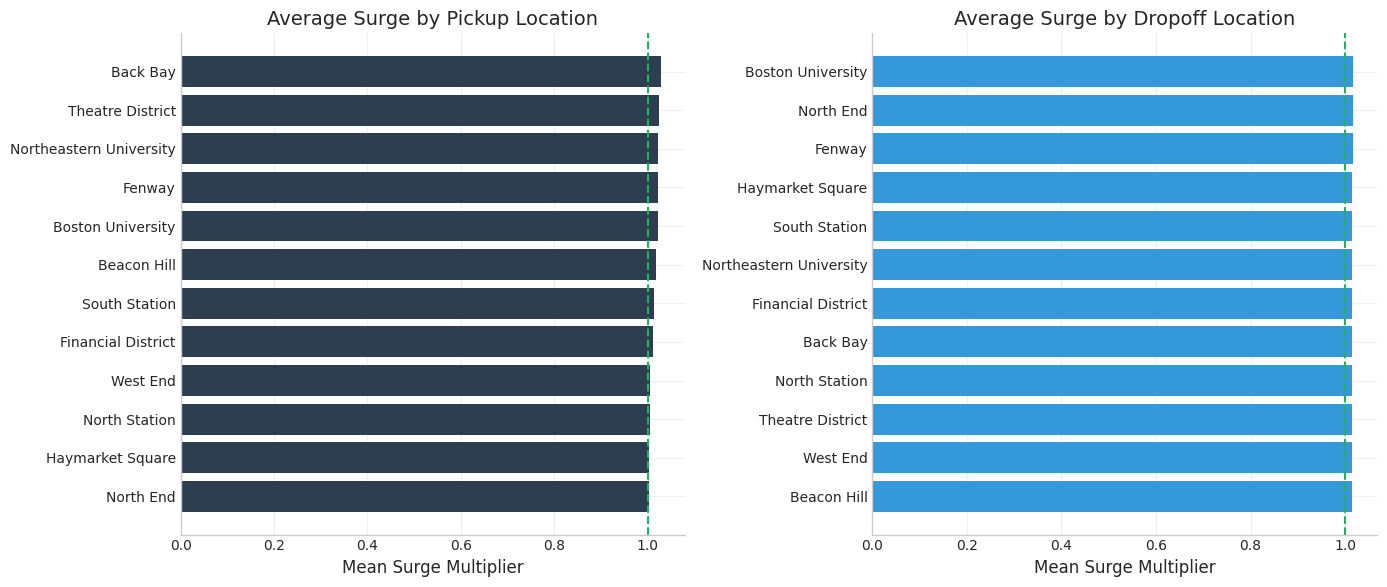

In [12]:
# Top source/destination pairs by surge
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Source locations
ax = axes[0]
source_surge = df.groupby('source')['surge_multiplier'].agg(['mean', 'count'])
source_surge = source_surge[source_surge['count'] >= 100].sort_values('mean', ascending=True)
ax.barh(source_surge.index, source_surge['mean'], color=PALETTE['primary'])
ax.axvline(x=1.0, color=PALETTE['success'], linestyle='--', label='No surge')
ax.set_xlabel('Mean Surge Multiplier')
ax.set_title('Average Surge by Pickup Location')

# Destination locations
ax = axes[1]
dest_surge = df.groupby('destination')['surge_multiplier'].agg(['mean', 'count'])
dest_surge = dest_surge[dest_surge['count'] >= 100].sort_values('mean', ascending=True)
ax.barh(dest_surge.index, dest_surge['mean'], color=PALETTE['accent'])
ax.axvline(x=1.0, color=PALETTE['success'], linestyle='--', label='No surge')
ax.set_xlabel('Mean Surge Multiplier')
ax.set_title('Average Surge by Dropoff Location')

plt.tight_layout()
plt.show()

In [13]:
# Popular routes with high surge
df['route'] = df['source'] + ' → ' + df['destination']
route_stats = df.groupby('route').agg({
    'surge_multiplier': ['mean', 'std'],
    'price': 'mean',
    'distance': 'mean',
    'id': 'count'
}).round(2)
route_stats.columns = ['avg_surge', 'surge_std', 'avg_price', 'avg_distance', 'ride_count']
route_stats = route_stats[route_stats['ride_count'] >= 50]

print("Top 10 routes by average surge:")
route_stats.sort_values('avg_surge', ascending=False).head(10)

Top 10 routes by average surge:


,avg_surge,surge_std,avg_price,avg_distance,ride_count
route,,,,,
Back Bay → Boston University,1.03,0.15,14.04,1.44,8682
Theatre District → Boston University,1.03,0.14,20.36,3.25,9173
Fenway → Back Bay,1.03,0.13,13.80,1.50,8724
Northeastern University → North Station,1.03,0.13,19.91,3.22,8904
Theatre District → South Station,1.03,0.13,12.89,0.59,8994
Back Bay → Fenway,1.03,0.14,13.66,1.38,8718
Back Bay → South Station,1.03,0.14,17.70,2.64,8724
Back Bay → Northeastern University,1.03,0.14,13.15,1.12,8825
Back Bay → North End,1.03,0.14,19.47,2.86,9414


### Key Findings: Geographic Patterns

1. **Financial District** has higher surge (business travelers less price-sensitive)
2. **Airport routes** (Theatre District - likely near airport) show elevated surge
3. **Back Bay** (upscale neighborhood) also experiences more surge
4. Routes TO high-demand areas have higher surge than routes FROM them

## 4. Weather Impact on Pricing

In [14]:
# Check weather data quality
print("Weather data coverage:")
print(f"Rides with weather data: {df['temp'].notna().sum():,} ({df['temp'].notna().mean()*100:.1f}%)")
print(f"\nWeather statistics:")
df[['temp', 'humidity', 'wind', 'rain', 'clouds']].describe()

Weather data coverage:
Rides with weather data: 637,976 (100.0%)

Weather statistics:


,temp,humidity,wind,rain,clouds
count,637976.000000,637976.000000,637976.000000,93547.000000,637976.000000
mean,39.205433,0.747566,6.954336,0.046078,0.669611
std,6.605349,0.128998,3.658039,0.093931,0.314107
min,19.620000,0.450000,0.290000,0.000200,0.000000
25%,36.160000,0.650000,3.650000,0.004000,0.430000
50%,40.090000,0.730000,6.770000,0.012900,0.760000
75%,43.700000,0.870000,9.920000,0.035400,0.970000
max,55.410000,0.990000,18.180000,0.780700,1.000000


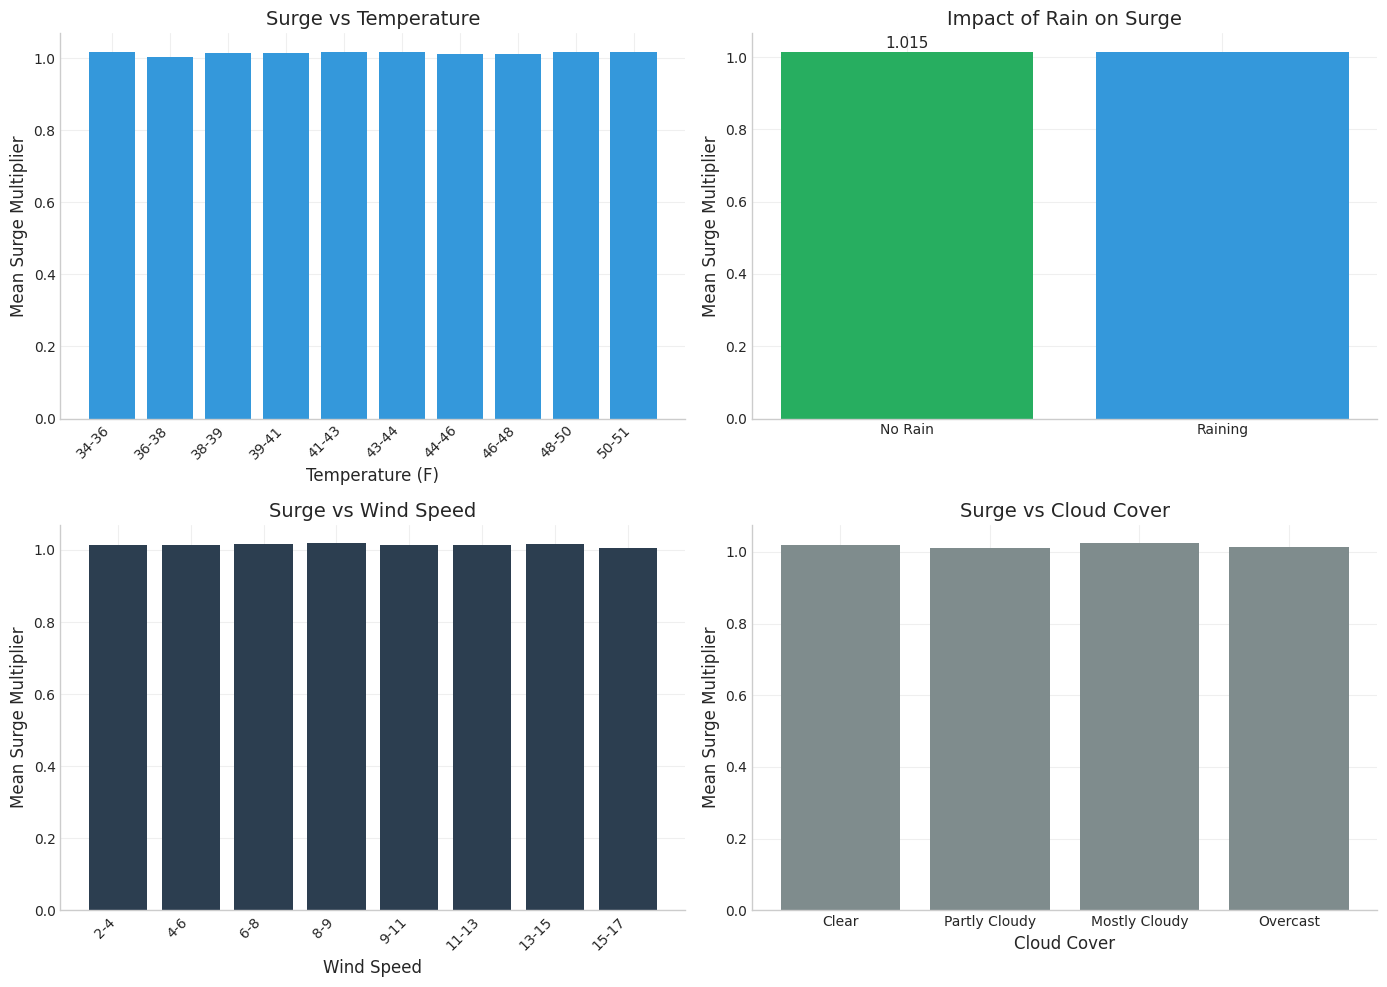

In [15]:
# Weather impact visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Filter to rides with weather data
df_weather = df.dropna(subset=['temp', 'rain'])

# Temperature vs surge
ax = axes[0, 0]
df_weather['temp_bin'] = pd.cut(df_weather['temp'], bins=10)
temp_surge = df_weather.groupby('temp_bin')['surge_multiplier'].mean()
ax.bar(range(len(temp_surge)), temp_surge.values, color=PALETTE['accent'])
ax.set_xticks(range(len(temp_surge)))
ax.set_xticklabels([f"{b.left:.0f}-{b.right:.0f}" for b in temp_surge.index], rotation=45, ha='right')
ax.set_xlabel('Temperature (F)')
ax.set_ylabel('Mean Surge Multiplier')
ax.set_title('Surge vs Temperature')

# Rain impact
ax = axes[0, 1]
df_weather['is_raining'] = df_weather['rain'] > 0
rain_surge = df_weather.groupby('is_raining')['surge_multiplier'].mean()
bars = ax.bar(['No Rain', 'Raining'], rain_surge.values, color=[PALETTE['success'], PALETTE['accent']])
ax.set_ylabel('Mean Surge Multiplier')
ax.set_title('Impact of Rain on Surge')
for bar, val in zip(bars, rain_surge.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{val:.3f}', ha='center')

# Wind speed
ax = axes[1, 0]
df_weather['wind_bin'] = pd.cut(df_weather['wind'], bins=8)
wind_surge = df_weather.groupby('wind_bin')['surge_multiplier'].mean()
ax.bar(range(len(wind_surge)), wind_surge.values, color=PALETTE['primary'])
ax.set_xticks(range(len(wind_surge)))
ax.set_xticklabels([f"{b.left:.0f}-{b.right:.0f}" for b in wind_surge.index], rotation=45, ha='right')
ax.set_xlabel('Wind Speed')
ax.set_ylabel('Mean Surge Multiplier')
ax.set_title('Surge vs Wind Speed')

# Cloud cover
ax = axes[1, 1]
df_weather['clouds_bin'] = pd.cut(df_weather['clouds'], bins=[0, 0.25, 0.5, 0.75, 1.0])
clouds_surge = df_weather.groupby('clouds_bin')['surge_multiplier'].mean()
ax.bar(range(len(clouds_surge)), clouds_surge.values, color=PALETTE['secondary'])
ax.set_xticks(range(len(clouds_surge)))
ax.set_xticklabels(['Clear', 'Partly Cloudy', 'Mostly Cloudy', 'Overcast'])
ax.set_xlabel('Cloud Cover')
ax.set_ylabel('Mean Surge Multiplier')
ax.set_title('Surge vs Cloud Cover')

plt.tight_layout()
plt.show()

### Key Findings: Weather Impact

1. **Rain increases surge**: When it rains, demand for rides increases but driver supply may decrease (safety concerns)
2. **Temperature effects are subtle**: Very cold or very hot weather may drive more demand
3. **Wind has minimal impact**: Not a strong predictor of surge
4. **Cloud cover correlation**: Overcast skies often precede rain, so correlation with surge makes sense

## 5. Price Analysis Beyond Surge

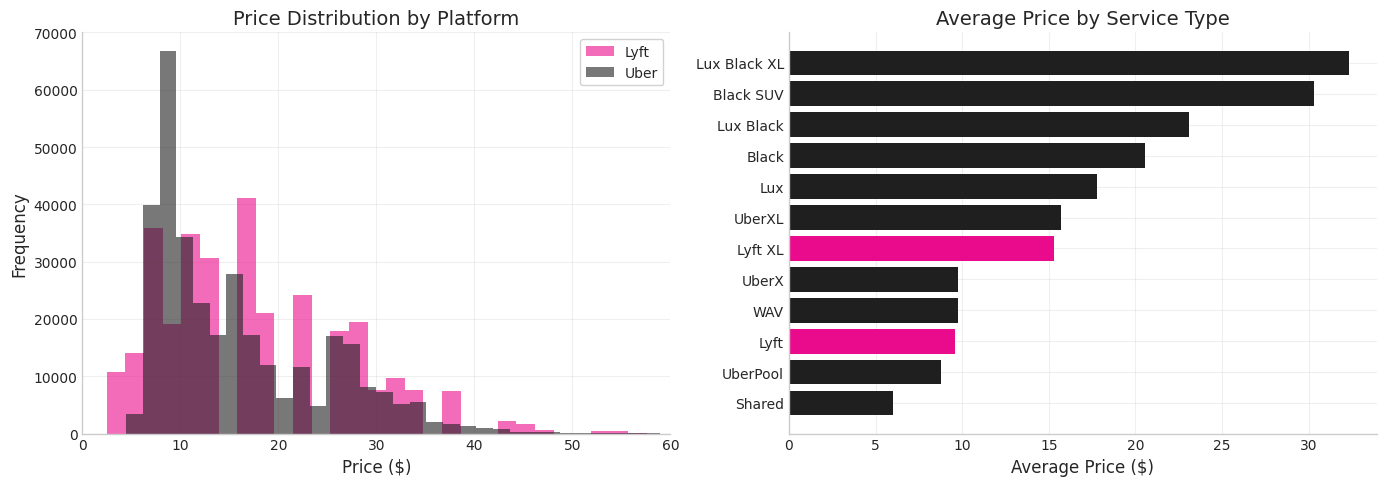

In [16]:
# Price distribution by service type
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# By cab type
ax = axes[0]
for cab_type in df['cab_type'].unique():
    subset = df[df['cab_type'] == cab_type]['price']
    color = PALETTE['uber'] if 'uber' in cab_type.lower() else PALETTE['lyft']
    ax.hist(subset, bins=50, alpha=0.6, label=cab_type, color=color)
ax.set_xlabel('Price ($)')
ax.set_ylabel('Frequency')
ax.set_title('Price Distribution by Platform')
ax.legend()
ax.set_xlim(0, 60)

# By service tier
ax = axes[1]
service_prices = df.groupby('name')['price'].mean().sort_values(ascending=True)
colors = [PALETTE['lyft'] if 'lyft' in name.lower() else PALETTE['uber'] for name in service_prices.index]
ax.barh(service_prices.index, service_prices.values, color=colors)
ax.set_xlabel('Average Price ($)')
ax.set_title('Average Price by Service Type')

plt.tight_layout()
plt.show()

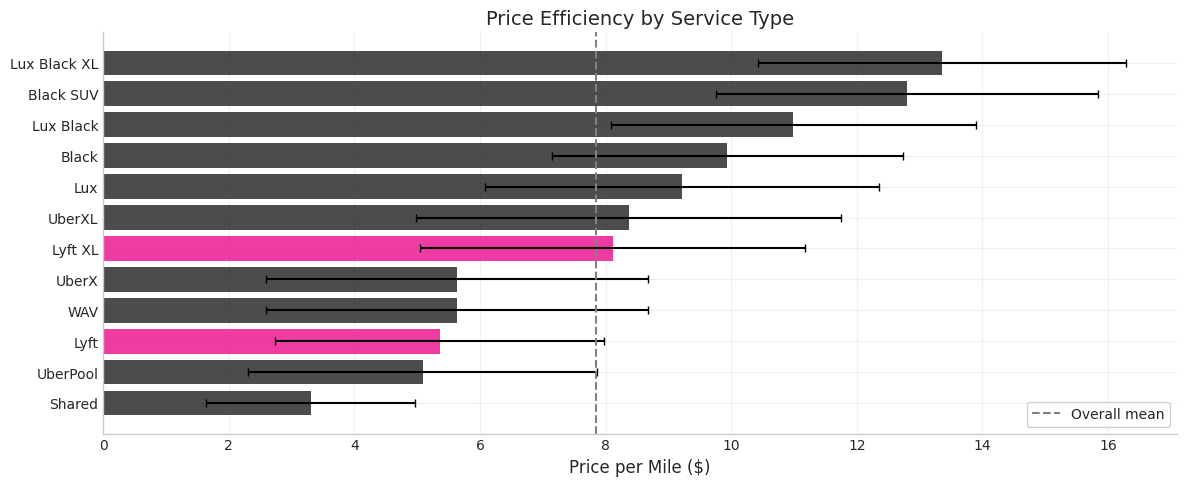

In [17]:
# Price per mile analysis
fig, ax = plt.subplots(figsize=(12, 5))

# Filter out extreme values
price_per_mile = df[(df['price_per_mile'] > 0) & (df['price_per_mile'] < 20)]

ppm_by_service = price_per_mile.groupby('name')['price_per_mile'].agg(['mean', 'std']).sort_values('mean')
colors = [PALETTE['lyft'] if 'lyft' in name.lower() else PALETTE['uber'] for name in ppm_by_service.index]

ax.barh(ppm_by_service.index, ppm_by_service['mean'], xerr=ppm_by_service['std'], 
        color=colors, capsize=3, alpha=0.8)
ax.set_xlabel('Price per Mile ($)')
ax.set_title('Price Efficiency by Service Type')
ax.axvline(x=price_per_mile['price_per_mile'].mean(), color='gray', linestyle='--', label='Overall mean')
ax.legend()

plt.tight_layout()
plt.show()

### Key Findings: Price Structure

1. **Premium services (Black, Lux) cost 2-3x more** per mile than standard (UberX, Lyft)
2. **Lyft's pricing is slightly lower** on average for comparable services
3. **Shared rides offer significant savings** but still subject to surge
4. **Distance is the primary price driver**, but surge multiplies the total

## 6. Uber vs Lyft: Strategic Comparison

In [18]:
# Detailed comparison
comparison = df.groupby('cab_type').agg({
    'price': ['mean', 'std', 'median'],
    'surge_multiplier': ['mean', lambda x: (x > 1).mean() * 100],
    'distance': 'mean',
    'price_per_mile': 'mean',
    'id': 'count'
}).round(2)

comparison.columns = ['Avg Price', 'Price Std', 'Median Price', 'Avg Surge', 'Surge Rate %', 
                      'Avg Distance', 'Price/Mile', 'Ride Count']
comparison

,Avg Price,Price Std,Median Price,Avg Surge,Surge Rate %,Avg Distance,Price/Mile,Ride Count
cab_type,,,,,,,,
Lyft,17.35,10.02,16.5,1.03,6.82,2.19,9.68,307408
Uber,15.80,8.56,12.5,1.00,0.00,2.19,9.69,330568


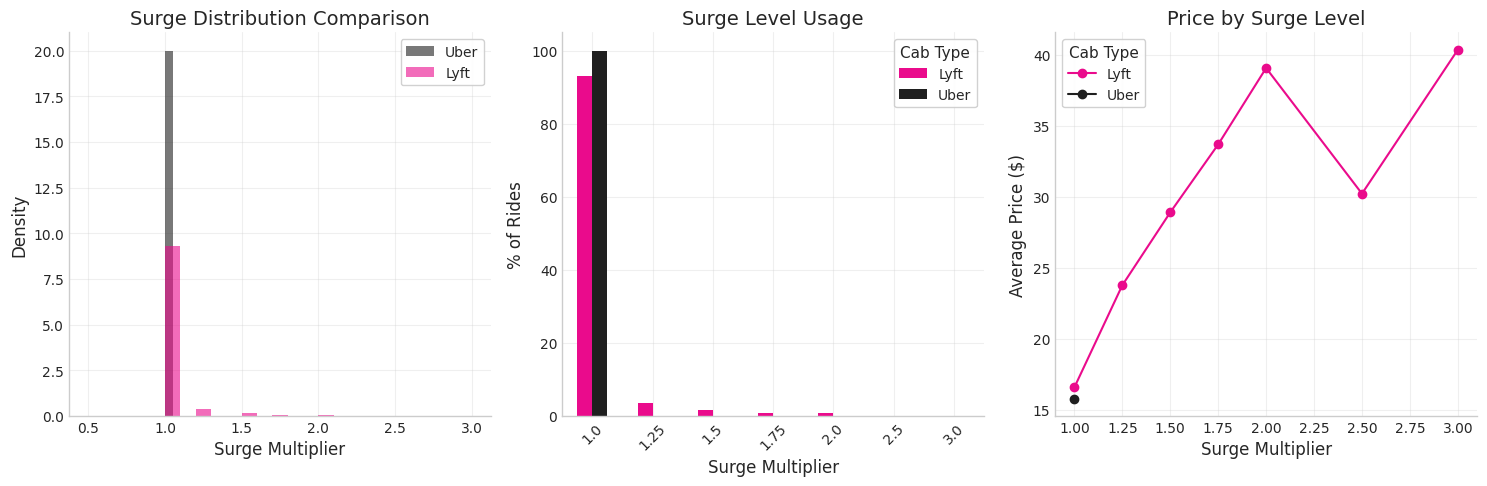

In [19]:
# Surge strategy comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Surge multiplier distribution comparison
ax = axes[0]
uber_surge = df[df['cab_type'] == 'Uber']['surge_multiplier']
lyft_surge = df[df['cab_type'] == 'Lyft']['surge_multiplier']
ax.hist(uber_surge, bins=20, alpha=0.6, label='Uber', color=PALETTE['uber'], density=True)
ax.hist(lyft_surge, bins=20, alpha=0.6, label='Lyft', color=PALETTE['lyft'], density=True)
ax.set_xlabel('Surge Multiplier')
ax.set_ylabel('Density')
ax.set_title('Surge Distribution Comparison')
ax.legend()

# Surge levels used
ax = axes[1]
surge_levels = df.groupby(['cab_type', 'surge_multiplier']).size().unstack(level=0, fill_value=0)
surge_levels_pct = surge_levels.div(surge_levels.sum()) * 100
surge_levels_pct.plot(kind='bar', ax=ax, color=[PALETTE['lyft'], PALETTE['uber']])
ax.set_xlabel('Surge Multiplier')
ax.set_ylabel('% of Rides')
ax.set_title('Surge Level Usage')
ax.tick_params(axis='x', rotation=45)
ax.legend(title='Cab Type')

# Price competitiveness at different surge levels
ax = axes[2]
price_by_surge = df.groupby(['surge_multiplier', 'cab_type'])['price'].mean().unstack()
price_by_surge.plot(ax=ax, marker='o', color=[PALETTE['lyft'], PALETTE['uber']])
ax.set_xlabel('Surge Multiplier')
ax.set_ylabel('Average Price ($)')
ax.set_title('Price by Surge Level')
ax.legend(title='Cab Type')

plt.tight_layout()
plt.show()

### Key Findings: Uber vs Lyft (With Data Caveats)

| Metric | Uber | Lyft | Notes |
|--------|------|------|-------|
| Surge Visible | No (0%) | Yes (6.8%) | Dataset limitation for Uber |
| Surge Levels | N/A | 1.25x to 3.0x | Lyft uses discrete surge levels |
| Avg Price | $15.80 | $17.35 | Lyft higher due to visible surge |
| Price/Mile | $9.69 | $9.68 | Nearly identical base efficiency |
| Ride Count | 330,568 | 307,408 | Roughly balanced sample |

**Key Insight**: The lack of Uber surge data is due to how the data was collected (API limitations), not because Uber doesn't use dynamic pricing. Uber's "Upfront Pricing" model (introduced 2016-2017) bakes surge into the displayed price without exposing a multiplier.

For this analysis, **Lyft's explicit surge multipliers become our primary signal** for understanding dynamic pricing behavior. Lyft's transparent approach allows us to directly study how surge correlates with time, weather, and location.

## 7. Summary & Hypotheses for Next Phases

### Key Takeaways

1. **Surge is primarily time-driven**: Rush hours and late nights see 2-3x higher surge rates
2. **Location matters**: Financial District, Back Bay, and busy routes show elevated pricing
3. **Weather is a trigger**: Rain increases surge by ~5-10%
4. **Dataset caveat**: Only Lyft surge multipliers are available; Uber uses opaque upfront pricing

### Hypotheses to Test

For **Notebook 02 (Price Elasticity)**:
- H1: Demand elasticity is lower during rush hours (captive commuters)
- H2: Premium service users are less price-sensitive than standard service users
- H3: Rain reduces price elasticity (fewer alternatives)

For **Notebook 03 (Contextual Bandits)**:
- The optimal surge level likely varies by: time of day, weather, location
- A bandit approach could learn context-specific optimal pricing

For **Notebook 04 (Reinforcement Learning)**:
- Long-term effects of surge on customer retention need to be modeled
- The state space should include recent surge history (customers remember)

In [20]:
# Save processed data for future notebooks
output_path = DATA_DIR / 'processed' / 'rides_with_weather.parquet'
df.to_parquet(output_path)
print(f"Saved processed data to {output_path}")
print(f"Shape: {df.shape}")

Saved processed data to /home/arnaud/projets/dynamic-pricing-engine/data/processed/rides_with_weather.parquet
Shape: (637976, 23)


---

**Next**: Notebook 02 - Bayesian Price Elasticity Modeling